In [1]:
#Import Modules

#GPyOpt - Cases are important, for some reason
import GPyOpt
from GPyOpt.methods import BayesianOptimization

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ
from advectionGP.test import TestKernels
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import multivariate_normal

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
X[:,1] = X[:,0]+1

sensors = FixedSensorModel(X,1) # establish sensor model

In [3]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,2) # x locations
yloc=np.linspace(2,8,2) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X2= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X2[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
X2[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
X2[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
X2[:,1] = X2[:,0]+1

sensors2 = FixedSensorModel(X2,1) # establish sensor model

In [4]:
# Generate concentration

k_0 = 0.004
noiseSD = 0.05
N_feat=1000 # number of features used to approximate GP
boundary = ([0,0,0],[10,10,10])# corners of the grid
k = EQ(2, 2.0) # generate EQ kernel
res = [50,30,30]

u=[]
u.append(np.ones(res)*0.001) #x direction wind
u.append(np.ones(res)*0.001) # y direction wind
windmodel=WindFixU(u) # establish fixed wind model

m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute test source
source=m.computeSourceFromPhi(z) # Compute test source
concTrain=m.computeConcentration(source) # Compute test concentration

# Generate training data (high sensor numbers)
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise

# Generate training data (low sensor numbers)
m.sensormodel = sensors2
yTrain2= m.computeObservations(addNoise='TRUE') # Compute observations with noise

(0.0, 10.0)

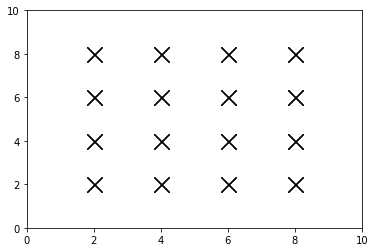

In [5]:
plt.plot(X[:,2],X[:,3],'xk',markersize=15)
plt.xlim(m.boundary[0][1],m.boundary[1][1])
plt.ylim(m.boundary[0][2],m.boundary[1][2])

(0.0, 10.0)

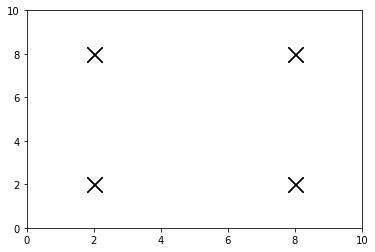

In [6]:
plt.plot(X2[:,2],X2[:,3],'xk',markersize=15)
plt.xlim(m.boundary[0][1],m.boundary[1][1])
plt.ylim(m.boundary[0][2],m.boundary[1][2])

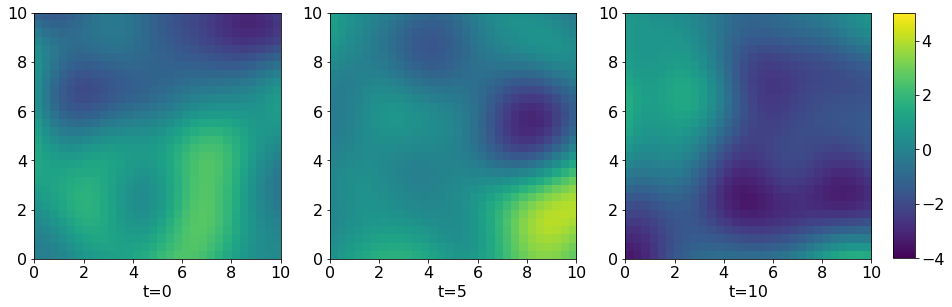

In [7]:
a=np.floor(np.min(source))
b=np.ceil(np.max(source))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(source[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(source[24], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(source[49], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

Example Source

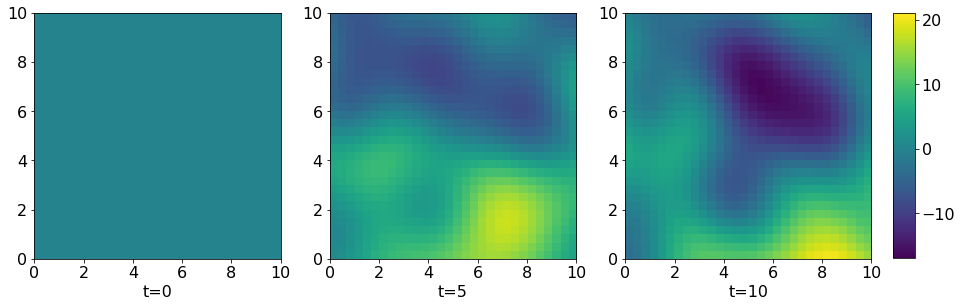

In [8]:
a=np.floor(np.min(concTrain))
b=np.ceil(np.max(concTrain))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(concTrain[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(concTrain[24], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(concTrain[49], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

Concentration Generated from example source

In [9]:
N_feat = 200
m1 = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model
X1 = m1.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = m1.computeZDistribution(yTrain) # Infers z vector mean and covariance
source1 = m1.computeSourceFromPhi(meanZ)

Calculating Adjoints...
79/80 
Calculating Phis...
199/200 


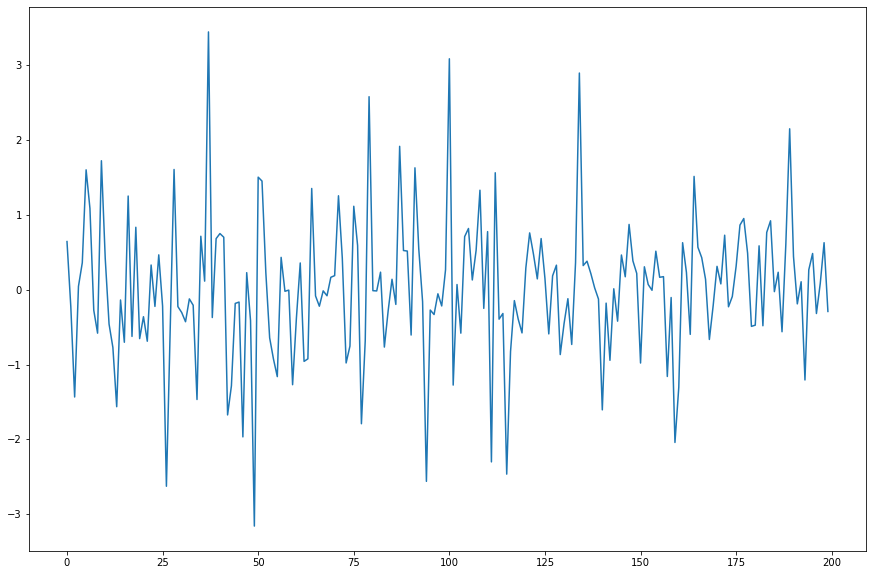

In [10]:
plt.plot(meanZ)

In [11]:
(np.square(np.subtract(source,source1))).mean()

0.845282261095559

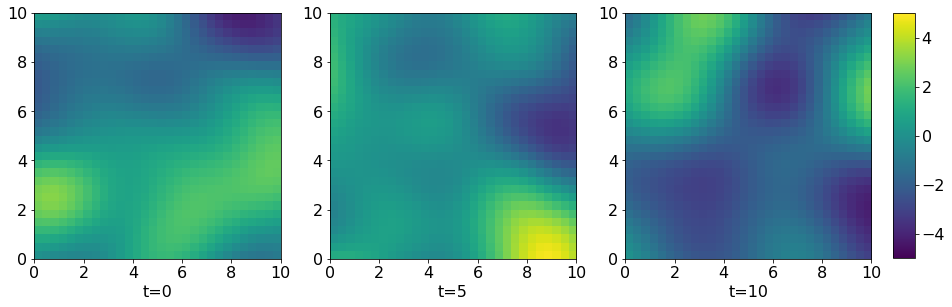

In [12]:
a=np.floor(np.min(source1))
b=np.ceil(np.max(source1))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(source1[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(source1[24], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(source1[49], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

Inferred source with 75 observations (25 sensors, 3 sample points)

In [13]:
N_feat = 200
m1.sensormodel=sensors2
X1 = m1.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = m1.computeZDistribution(yTrain2) # Infers z vector mean and covariance
source2 = m1.computeSourceFromPhi(meanZ)

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


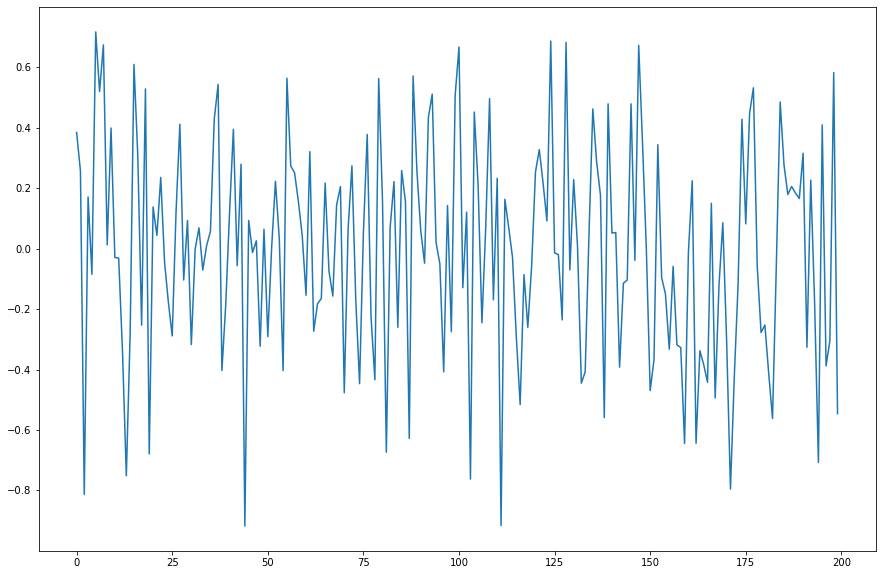

In [14]:
plt.plot(meanZ)

In [15]:
(np.square(np.subtract(source,source2))).mean()

1.235728237146765

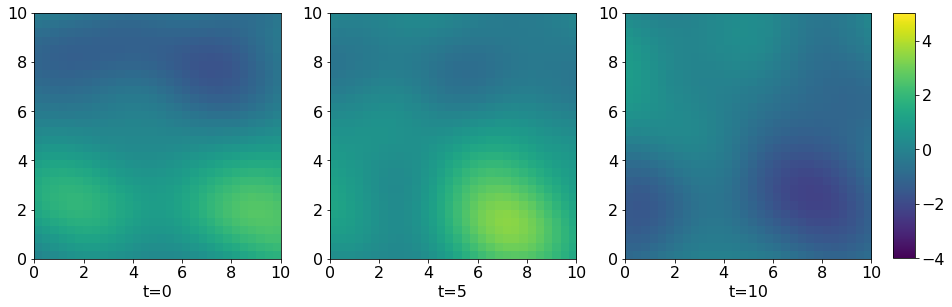

In [16]:
a=np.floor(np.min(source2))
b=np.ceil(np.max(source2))
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()

plt.subplot(131)
im1=plt.imshow(source2[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(132)
im2=plt.imshow(source2[24], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(133)
im3=plt.imshow(source2[49], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=10",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.92, 0.395, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

Inferred source with 12 observations (4 sensors, 3 sample points)